# Neutron-CT

This notebook demonstrates how to process neutron computed tomography (neutron-CT) data acquired at the ISIS Neutron and Muon Source IMAT beamline. We start from raw radiographs together with dark and flat fields, correct for detector artefacts, construct sinograms, determine the centre of rotation, clean the data, and finally reconstruct the 3D volume.


## 1. Setup and Imports

We begin by importing the required libraries and utility functions from **nDTomo**. These include modules for reconstruction (`astra_rec_single`, `astra_rec_vol`), sinogram scaling and centering (`scalesinos`, `sinocentering`), circular masking (`cirmask`), and an interactive data viewer (`ImageSpectrumGUI`). Standard scientific Python libraries (`numpy`, `matplotlib`, `h5py`, `tifffile`) are also used for data handling and visualisation.


In [ ]:
from nDTomo.methods.hyperexpl import chemimexplorer, ImageSpectrumGUI
from nDTomo.tomo.astra_tomo import astra_rec_single, astra_rec_vol
from nDTomo.tomo.sinograms import scalesinos, sinocentering
from nDTomo.methods.misc import cirmask

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tifffile import tifffile

%matplotlib qt


## 2. Scan Information

The dataset corresponds to a full 360° neutron CT scan of lithium-ion battery samples. Key parameters include:

- Number of projections: 429  
- Pixel size: 0.055 mm  
- Dark frames: 30  
- Flat fields: 10 before + 10 after the scan  
- Image size: 2048 × 2048 pixels  

Documenting these parameters is crucial for reproducibility and for setting up the correct reconstruction geometry later.


## 3. Loading Dark and Flat Fields

Dark fields (beam off) capture detector background signal, while flat fields (beam on, no sample) capture the illumination profile. Both are averaged to reduce noise. Here we load all darks and flats, compute the mean images, and combine the pre- and post-scan flats to create a representative flat field for the entire scan.

**Why this matters:** flat/dark correction compensates for detector non-uniformities and beam profile, ensuring that the final reconstructed volume reflects true sample attenuation.


In [2]:

ndarks = 30
nflats_before = 10
nflats_after = 10
image_rows = 2048
image_cols = 2048
nproj = 430

p = 'X:\\_neutronct\\'

datasets = ['AAA_D003C2Top_D100C20', 'AAA_PristineMiddle', 'AAA_C004C2Top_C002C20']

dd = 0

# Load the darks
dark = np.zeros((image_rows, image_cols, ndarks), dtype=np.float32)
for ii in tqdm(range(ndarks)):
    fn = '%s%s\\Tomo\\Dark_before%04d.tif' %(p, datasets[dd], ii)
    img = tifffile.imread(fn)
    dark[:, :, ii] = img
dark = np.mean(dark, axis=2)

#% Load the flats before the scan
flat_before = np.zeros((image_rows, image_cols, nflats_before), dtype=np.float32)
for ii in tqdm(range(nflats_before)):
    fn = '%s%s\\Flat_Before\\IMAT00016739_AAA_D003C2Top_D100C20_Flat_Before_%03d.tif' %(p, datasets[dd], ii)
    img = tifffile.imread(fn)
    flat_before[:, :, ii] = img

# Load the flats after the scan
flat_after = np.zeros((image_rows, image_cols, nflats_after), dtype=np.float32)
for ii in tqdm(range(nflats_after)):
    fn = '%s%s\\Flat_After\\IMAT00016742_AAA_D003C2Top_D100C20_Flat_After_%03d.tif' %(p, datasets[dd], ii)
    img = tifffile.imread(fn)
    flat_after[:, :, ii] = img

flat_before = np.mean(flat_before, axis=2)
flat_after = np.mean(flat_after, axis=2)

flat = (flat_before + flat_after)/2

100%|██████████| 10/10 [00:01<00:00,  9.02it/s]


## 4. Visual Inspection of Dark and Flat Fields

We visualise the averaged flat and dark fields. This step helps detect saturated regions, hot pixels, or illumination inhomogeneities before applying corrections.

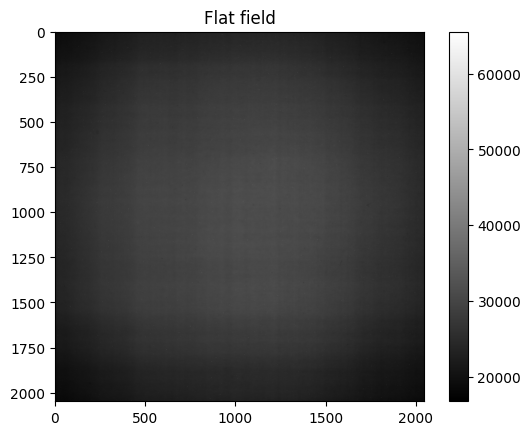

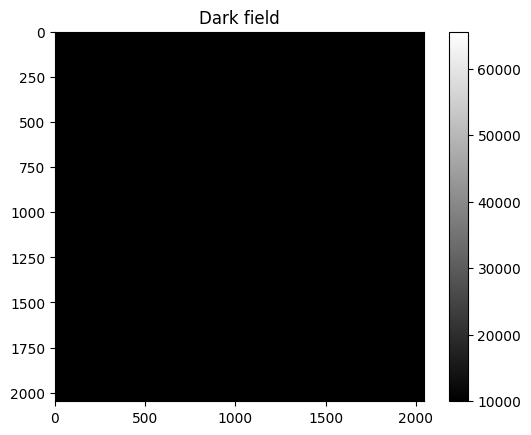

In [3]:
plt.figure(1);plt.clf()
plt.imshow(flat, cmap = 'gray')
plt.colorbar()
plt.title('Flat field')
plt.show()

plt.figure(2);plt.clf()
plt.imshow(dark, cmap = 'gray')
plt.colorbar()
plt.title('Dark field')
plt.clim(10000, np.max(dark))
plt.show()


## 5. Loading Radiographs

We then load the full stack of radiographs (projections at multiple rotation angles). Each radiograph is stored as a TIFF image. Averaging them provides a “mean radiograph,” which can be inspected to reveal systematic detector artefacts such as lines or bad pixels.

100%|██████████| 430/430 [01:02<00:00,  6.87it/s]


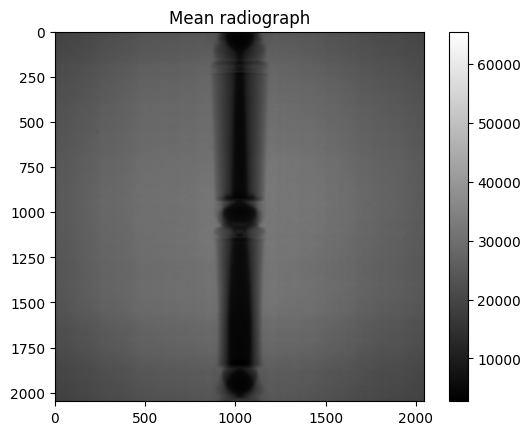

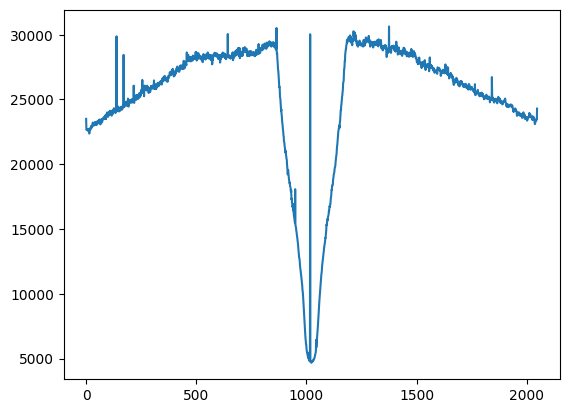

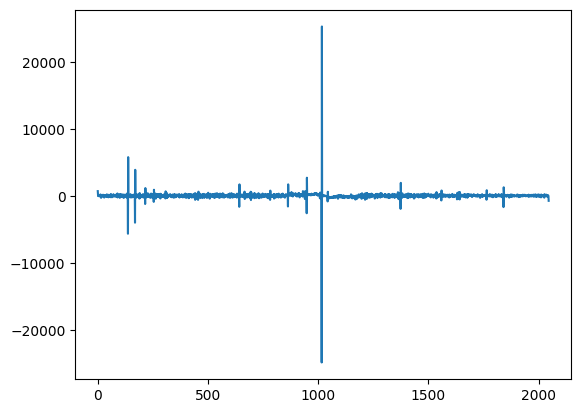

In [4]:
radios = np.zeros((image_rows, image_cols, nproj), dtype=np.float32)
for ii in tqdm(range(nproj)):
    fn = '%s%s\\Tomo\\IMAT00016741_AAA_D003C2Top_D100C20_Tomo_%03d.tif' %(p, datasets[dd], ii)
    img = tifffile.imread(fn)
    radios[:, :, ii] = img

mean_radio = np.mean(radios, axis=2)

plt.figure(3);plt.clf()
plt.imshow(mean_radio, cmap = 'gray')
plt.colorbar()
plt.title('Mean radiograph')
plt.show()

plt.figure(4);plt.clf()
plt.plot(mean_radio[442,:])
plt.show()

plt.figure(5);plt.clf()
plt.plot(mean_radio[442,:-1] - mean_radio[442,1:])
plt.show()


## 6. Identifying Detector Artefacts (“Sick Pixels”)

By computing differences between neighbouring columns and rows, we highlight pixels with abnormally large jumps in intensity. These so-called “sick pixels” often appear as streaks in sinograms if left uncorrected. We visualise these differences to identify problematic detector regions.


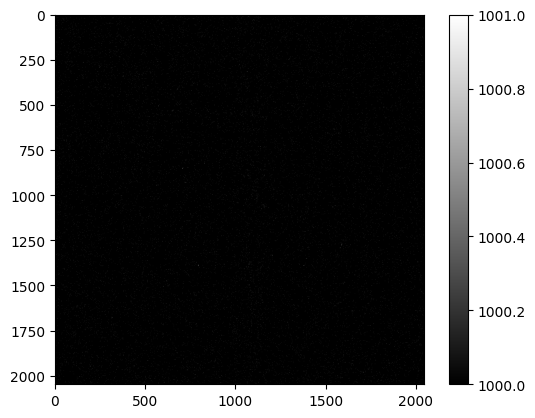

In [5]:

diff_cols = np.diff(mean_radio, axis=1)

thr = 1E3

plt.figure(4);plt.clf()
plt.imshow(diff_cols, cmap = 'gray')
plt.colorbar()
plt.clim(thr, thr+1)
plt.show()

sick_pixels = np.where(diff_cols > thr)

## 7. Correcting Sick Pixels

A correction routine is applied where anomalous pixels are replaced with the mean of their neighbours. This is performed both on column and row anomalies, with careful handling of border cases. We compare corrected vs. uncorrected flat/dark fields to confirm improvements.

**Why this matters:** detector artefacts propagate directly into ring artefacts in reconstruction. Correcting them early produces cleaner volumes.


100%|██████████| 16230/16230 [00:00<00:00, 85793.09it/s]


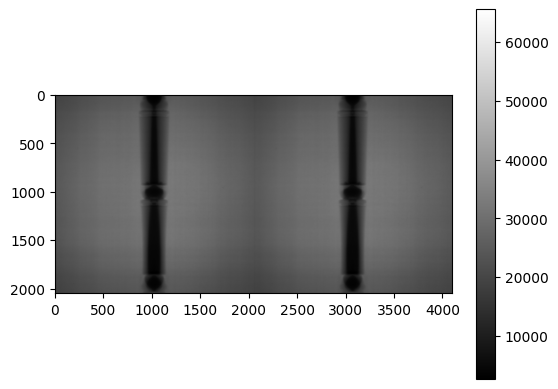

In [6]:

# Compute differences along columns and rows
diff_cols = np.diff(mean_radio, axis=1)
diff_rows = np.diff(mean_radio, axis=0)

# Identify "sick" pixels where the difference exceeds the threshold
sick_pixels_cols = np.where(diff_cols > thr)
sick_pixels_rows = np.where(diff_rows > thr)

tmp = np.copy(mean_radio)

# Handle "sick" pixels from column differences
n_sick_cols = len(sick_pixels_cols[0])
for ii in range(n_sick_cols):
    row = sick_pixels_cols[0][ii]       
    col = sick_pixels_cols[1][ii]  
    
    # Handle column border cases
    if col - 1 >= 0 and col + 1 < img.shape[1]:  # Not at the left or right border
        img[row, col] = np.mean([img[row, col - 1], img[row, col + 1]])
    elif col - 1 < 0:  # At the left border, take only the right neighbor
        img[row, col] = img[row, col + 1]
    elif col + 1 >= img.shape[1]:  # At the right border, take only the left neighbor
        img[row, col] = img[row, col - 1]

# Handle "sick" pixels from row differences
n_sick_rows = len(sick_pixels_rows[0])
for ii in tqdm(range(n_sick_rows)):
    row = sick_pixels_rows[0][ii] + 1  # Adjust row index by +1 for `diff_rows`
    col = sick_pixels_rows[1][ii]     # Column index
    
    # Handle row border cases
    if row - 1 >= 0 and row + 1 < tmp.shape[0]:  # Not at the top or bottom border
        tmp[row, col] = np.mean([tmp[row - 1, col], tmp[row + 1, col]])
    elif row - 1 < 0:  # At the top border, take only the bottom neighbor
        tmp[row, col] = tmp[row + 1, col]
    elif row + 1 >= tmp.shape[0]:  # At the bottom border, take only the top neighbor
        tmp[row, col] = tmp[row - 1, col]

plt.figure(4);plt.clf()
plt.imshow(np.concatenate((tmp,mean_radio), axis =1), cmap = 'gray')
plt.colorbar()
plt.show()

In [7]:

def correct_sick_pixels_image(img, sick_pixels_cols, sick_pixels_rows):

    # Handle "sick" pixels from column differences
    n_sick_cols = len(sick_pixels_cols[0])
    for ii in range(n_sick_cols):
        row = sick_pixels_cols[0][ii]       
        col = sick_pixels_cols[1][ii]  
        
        # Handle column border cases
        if col - 1 >= 0 and col + 1 < img.shape[1]:  # Not at the left or right border
            img[row, col] = np.mean([img[row, col - 1], img[row, col + 1]])
        elif col - 1 < 0:  # At the left border, take only the right neighbor
            img[row, col] = img[row, col + 1]
        elif col + 1 >= img.shape[1]:  # At the right border, take only the left neighbor
            img[row, col] = img[row, col - 1]

    # Handle "sick" pixels from row differences
    n_sick_rows = len(sick_pixels_rows[0])
    for ii in range(n_sick_rows):
        row = sick_pixels_rows[0][ii] + 1  # Adjust row index by +1 for `diff_rows`
        col = sick_pixels_rows[1][ii]     # Column index
        
        # Handle row border cases
        if row - 1 >= 0 and row + 1 < img.shape[0]:  # Not at the top or bottom border
            img[row, col] = np.mean([img[row - 1, col], img[row + 1, col]])
        elif row - 1 < 0:  # At the top border, take only the bottom neighbor
            img[row, col] = img[row + 1, col]
        elif row + 1 >= img.shape[0]:  # At the bottom border, take only the top neighbor
            img[row, col] = img[row - 1, col]

    return img

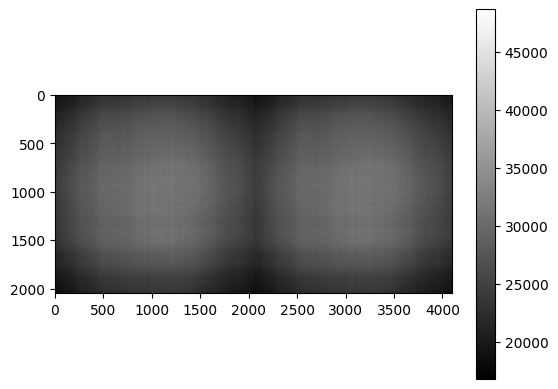

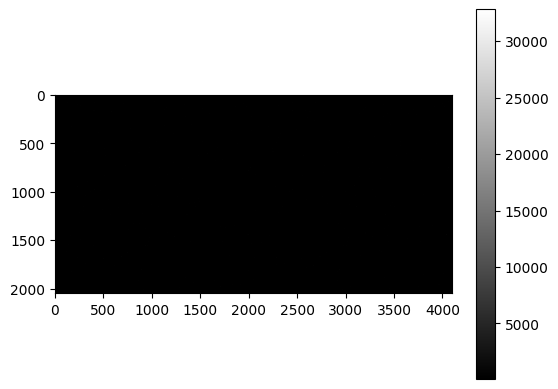

In [8]:

flat_cor = correct_sick_pixels_image(flat, sick_pixels_cols, sick_pixels_rows)
dark_cor = correct_sick_pixels_image(dark, sick_pixels_cols, sick_pixels_rows)

plt.figure(1);plt.clf()
plt.imshow(np.concatenate((flat_cor,flat), axis =1), cmap = 'gray')
plt.colorbar()
plt.show()

plt.figure(2);plt.clf()
plt.imshow(np.concatenate((dark_cor,dark), axis =1), cmap = 'gray')
plt.colorbar()
plt.show()

## 8. Flat/Dark Normalisation of Radiographs

Each radiograph is corrected according to:
\[
I_\text{corr} = \frac{I - D}{F - D}
\]
where \(I\) is the raw image, \(D\) the averaged dark, and \(F\) the averaged flat. Sick pixel correction is reapplied if needed after normalisation. The result is a consistent, normalised radiograph stack.


In [9]:

thr_norm = 0.1

radios = np.zeros((image_rows, image_cols, nproj), dtype=np.float32)
for ii in tqdm(range(nproj)):

    fn = '%s%s\\Tomo\\IMAT00016741_AAA_D003C2Top_D100C20_Tomo_%03d.tif' %(p, datasets[dd], ii)
    img = tifffile.imread(fn)
    img = np.array(img, dtype=np.float32)
    img = correct_sick_pixels_image(img, sick_pixels_cols, sick_pixels_rows)
    img = (img - dark_cor)/(flat_cor - dark_cor)

    # Compute differences along columns and rows
    diff_cols = np.diff(img, axis=1)
    diff_rows = np.diff(img, axis=0)

    # Identify "sick" pixels where the difference exceeds the threshold
    sick_pixels_cols_radio = np.where(diff_cols > thr_norm)
    sick_pixels_rows_radio = np.where(diff_rows > thr_norm)

    radios[:, :, ii] = correct_sick_pixels_image(img, sick_pixels_cols_radio, sick_pixels_rows_radio)


100%|██████████| 430/430 [03:56<00:00,  1.82it/s]


## 9. Quick Interactive Inspection

The **ImageSpectrumGUI** is launched to interactively browse through the corrected radiographs. This provides immediate visual confirmation that correction has worked as expected and helps spot any remaining anomalies.


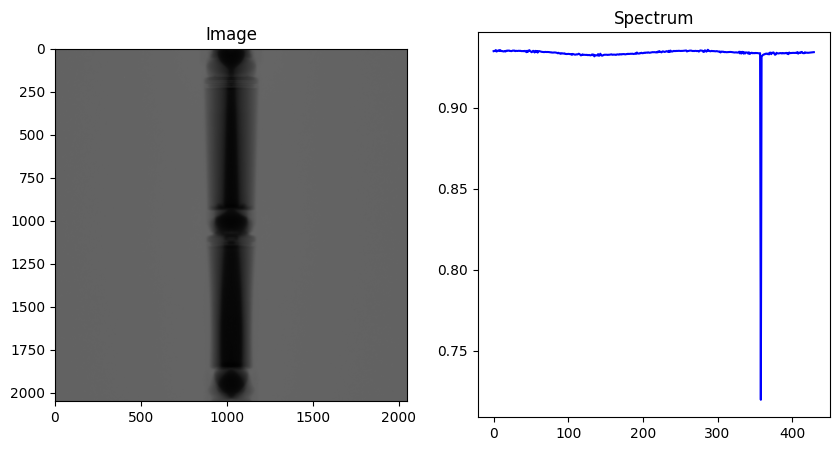

In [13]:
ImageSpectrumGUI(np.transpose(radios, (1,0,2)), cmap='gray')


## 10. Log Transformation and Initial Sinogram Construction

The corrected images are converted to line integrals using a negative log transform, scaled by the pixel size. Sinograms are created by stacking line profiles across projections. Subtraction of the “air” signal removes background offset. Negative values are set to zero. Finally, we apply sinogram scaling and coarse centre-of-rotation (CoR) alignment.

**Tip:** A misaligned CoR produces doubled or blurred features in reconstructions — so CoR estimation is critical.


Calculating the COR


100%|██████████| 200/200 [00:00<00:00, 634.10it/s]


Calculated COR: 173.19999999999948
Applying the COR correction


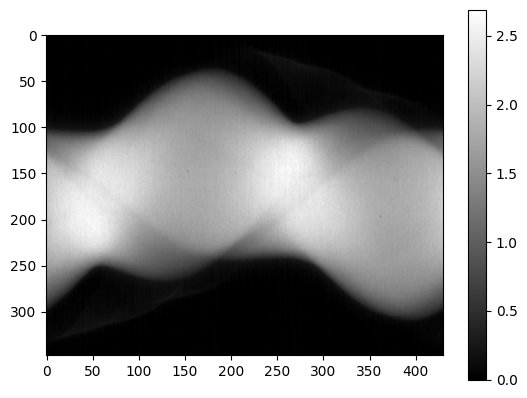

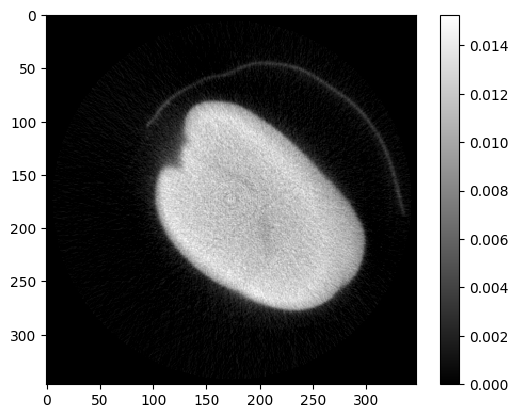

In [14]:

ch = 1969
sa = -np.log(radios[ch,850:-850,:])
for ii in range(sa.shape[1]):
    sa[:,ii] = sa[:,ii] - sa[0,ii]
sa[sa<0] = 0
sa = scalesinos(sa)
sa = sinocentering(sa, 10, scan=360)
theta = np.deg2rad(np.linspace(0, 360, nproj))

fbp = astra_rec_single(sa, theta = theta)
fbp = cirmask(fbp, 5)
fbp[fbp<0] = 0

plt.figure(5);plt.clf()
plt.imshow(sa, cmap='gray')
plt.colorbar()
plt.show()

plt.figure(6);plt.clf()
plt.imshow(fbp, cmap='gray', interpolation = 'none')    
plt.colorbar()
plt.show()

In [15]:
pixel_size = 0.055
sinos = -np.log(np.copy(radios[:,850:-850,:]) * pixel_size)
sinos = np.transpose(sinos, (1, 2, 0))
air = np.mean(sinos[:10,:10,:], axis = (0,1))
for ii in tqdm(range(sinos.shape[1])):
    sinos[:,ii,:] = sinos[:,ii,:] - air
sinos[sinos<0] = 0
sinos = scalesinos(sinos)
sinos = sinocentering(sinos, 10, scan=360, pbar=True)
print(sinos.shape)


100%|██████████| 430/430 [00:07<00:00, 56.29it/s]


Calculating the COR


100%|██████████| 200/200 [00:00<00:00, 665.23it/s]


Calculated COR: 173.19999999999948
Applying the COR correction


100%|██████████| 2048/2048 [00:11<00:00, 185.47it/s]


(347, 430, 2048)


## 11. Visualising Sinograms

We use **ImageSpectrumGUI** again to inspect the sinograms interactively. This step allows identification of residual detector artefacts (e.g., stripes, zingers, or anomalous projection bands).


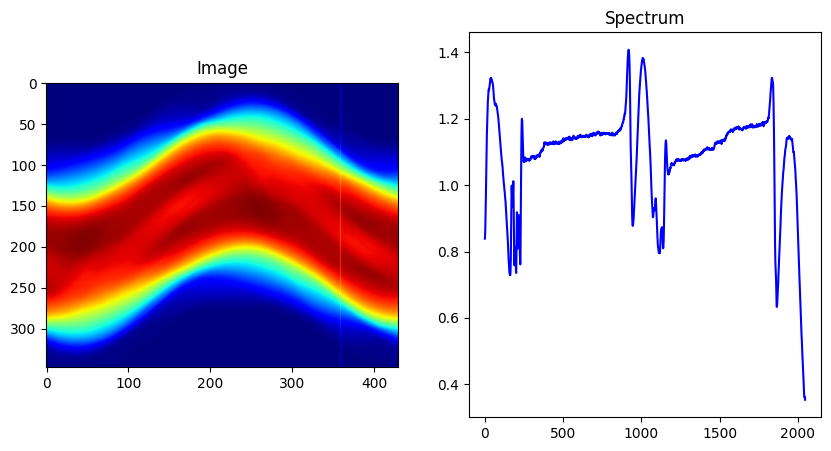

In [16]:
ImageSpectrumGUI(np.transpose(sinos, (1,0,2)))


## 12. Cleaning Sinograms

Several routines are provided to correct sinogram artefacts:

- **Projection spectrum correction**: fixes entire projection columns with anomalies.  
- **Zinger correction**: replaces isolated anomalous pixels with interpolated values.  
- **Detector pixel correction**: addresses entire rows affected by detector inconsistencies.  

We demonstrate these methods on single sinograms and then apply them iteratively across the full dataset.

**Why this matters:** cleaned sinograms produce reconstructions with fewer streaks, stripes, and false features.


In [17]:

def correct_sinogram_zingers(sinogram, thr_norm = 0.1):

    """
    Corrects "zingers" (anomalous high-intensity values) in a sinogram by detecting 
    abrupt changes in intensity between adjacent columns and replacing the problematic 
    values with interpolated estimates.

    Parameters:
    ----------
    sinogram : numpy.ndarray
        Input 2D sinogram array with shape (detector elements, projections).
    
    thr_norm : float, optional (default=0.1)
        Threshold for detecting anomalous differences in column intensity. 
        Differences greater than this threshold are flagged as "sick" pixels.

    Returns:
    -------
    numpy.ndarray
        Sinogram with corrected "zinger" values.

    Notes:
    -----
    - Anomalous pixels are identified as those where the intensity difference 
      between adjacent columns exceeds `thr_norm`.
    - Detected anomalous pixels are replaced with the mean of their left and right neighbors.
    - Special handling is applied to border pixels:
        - Left border: Replaced with the right neighbor's value.
        - Right border: Replaced with the left neighbor's value.

    """

    diff_cols = np.diff(sinogram, axis=1)
    sick_pixels = np.where(diff_cols > thr_norm)

    # Handle "sick" pixels from column differences
    n_sick_cols = len(sick_pixels[0])
    for ii in range(n_sick_cols):
        row = sick_pixels[0][ii]       
        col = sick_pixels[1][ii]  
        
        # Handle column border cases
        if col - 1 >= 0 and col + 1 < sinogram.shape[1]:  # Not at the left or right border
            sinogram[row, col] = np.mean([sinogram[row, col - 1], sinogram[row, col + 1]])
        elif col - 1 < 0:  # At the left border, take only the right neighbor
            sinogram[row, col] = sinogram[row, col + 1]
        elif col + 1 >= sinogram.shape[1]:  # At the right border, take only the left neighbor
            sinogram[row, col] = sinogram[row, col - 1]
    return sinogram

def correct_sinogram_detector_pixel(sinogram, thr_norm = 0.1, its=1):

    """
    Corrects detector pixel anomalies in a sinogram by identifying rows with 
    abrupt changes in intensity and replacing them with the mean of their adjacent rows.

    Parameters:
    ----------
    sinogram : numpy.ndarray
        Input 2D sinogram array with shape (detector elements, projections).
    
    thr_norm : float, optional (default=0.1)
        Threshold for detecting anomalous differences in row intensity. 
        Differences greater than this threshold are flagged as "sick" pixels.

    its : int, optional (default=1)
        Number of iterations to perform the correction process.

    Returns:
    -------
    numpy.ndarray
        Sinogram with corrected detector pixel anomalies.

    Notes:
    -----
    - In each iteration, the function:
        1. Identifies rows with differences exceeding `thr_norm` between adjacent rows.
        2. Replaces the most frequently detected anomalous row with the mean of its adjacent rows.
    - This iterative approach ensures robust correction of significant detector artifacts.
    - Edge cases are not handled explicitly; ensure valid input dimensions for proper operation.

    """

    for ii in range(its):
        diff_rows = np.diff(sinogram, axis=0)
        sick_pixels_rows_radio = np.where(diff_rows > thr_norm)
        h = np.copy(sick_pixels_rows_radio[0])
        # Find unique values and their counts
        values, rows = np.unique(h, return_counts=True)
        # Get the most common value and its frequency
        most_common_row = values[np.argmax(rows)] + 1
        sinogram[most_common_row,:] = (sinogram[most_common_row - 1,:] + sinogram[most_common_row + 1,:])/2

    return sinogram
            
def correct_sinogram_proj_spectrum(sinogram, thr_norm = 0.1):

    """
    Corrects projection spectrum anomalies in a sinogram by detecting abrupt changes 
    in intensity across adjacent columns and replacing the problematic projection 
    column with interpolated estimates.

    Parameters:
    ----------
    sinogram : numpy.ndarray
        Input 2D sinogram array with shape (detector elements, projections).
    
    thr_norm : float, optional (default=0.1)
        Threshold for detecting anomalous differences in column intensity. 
        Differences greater than this threshold are flagged as anomalies.

    Returns:
    -------
    numpy.ndarray
        Sinogram with corrected projection spectrum anomalies.

    Notes:
    -----
    - Anomalies are identified by detecting differences in column intensities 
      across adjacent columns exceeding `thr_norm`.
    - The column with the most frequent anomalies is identified and replaced 
      with the mean of its adjacent columns.
    - Special handling is required to ensure the problematic column is not at 
      the edges (first or last column), as these cannot be interpolated.
    """

    diff_cols = np.diff(sinogram, axis=1)
    sick_pixels_cols_radio = np.where(diff_cols > thr_norm)
    h = np.copy(sick_pixels_cols_radio[1])
    # Find unique values and their counts
    values, cols = np.unique(h, return_counts=True)
    # Get the most common value and its frequency
    most_common_col = values[np.argmax(cols)] + 1
    sinogram[:,most_common_col] = (sinogram[:,most_common_col- 1] + sinogram[:,most_common_col + 1])/2

    return sinogram

## 13. Slice Reconstruction (2D)

As a test, we reconstruct a single slice using filtered back-projection (FBP). The sinogram is corrected, the CoR applied, and the reconstruction performed. A circular mask is applied to crop the valid field of view. The resulting image is inspected for quality.


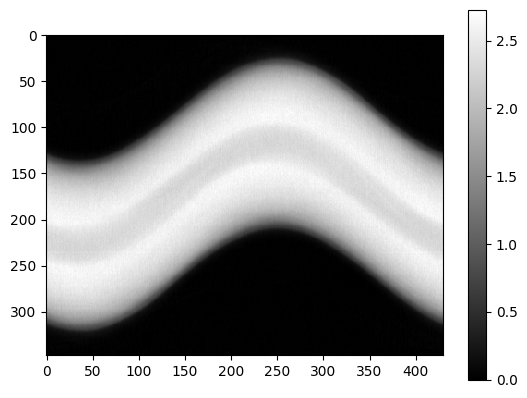

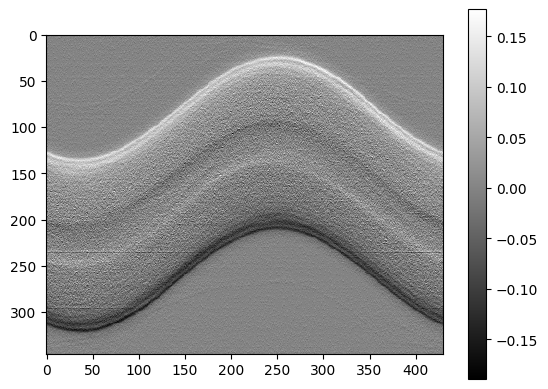

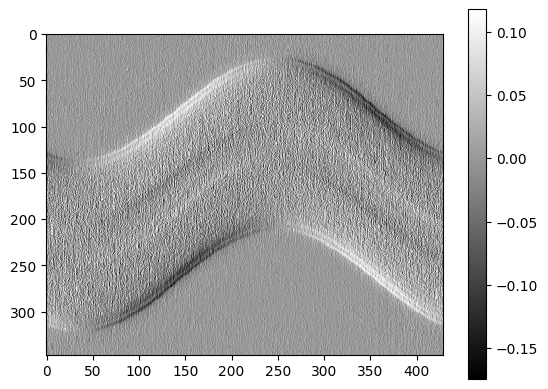

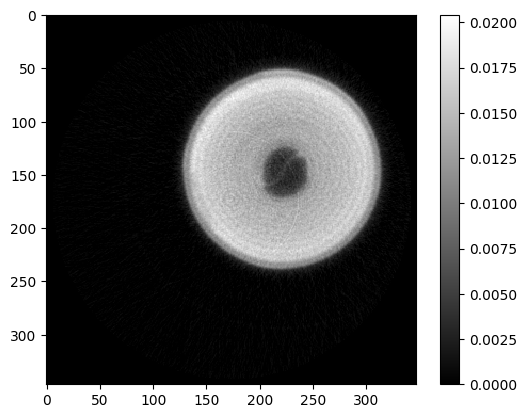

In [18]:

soi = np.copy(sinos[:,:,717])

# Compute differences along columns and rows

soi = correct_sinogram_proj_spectrum(soi, thr_norm = 0.1)
soi = correct_sinogram_zingers(soi, thr_norm = 0.1)
soi = correct_sinogram_detector_pixel(soi, thr_norm = 0.1, its=2)

theta = np.deg2rad(np.linspace(0, 360, nproj))
fbp = astra_rec_single(soi, theta = theta)
fbp = cirmask(fbp, 5)
fbp[fbp<0] = 0

plt.figure(5);plt.clf()
plt.imshow(soi, cmap='gray', interpolation = 'none')    
plt.colorbar()
plt.show()

plt.figure(6);plt.clf()
plt.imshow(np.diff(soi, axis=0), cmap='gray', interpolation = 'none')    
plt.colorbar()
plt.show()

plt.figure(7);plt.clf()
plt.imshow(np.diff(soi, axis=1), cmap='gray', interpolation = 'none')    
plt.colorbar()
plt.show()

plt.figure(8);plt.clf()
plt.imshow(fbp, cmap='gray', interpolation = 'none')    
plt.colorbar()
plt.show()

## 14. Volume Reconstruction (3D)

After cleaning all sinograms, we perform full 3D reconstruction with `astra_rec_vol`. The result is a volumetric dataset representing the internal structure of the battery. Again, a circular mask is applied and negative values are clipped.


In [19]:
theta = np.deg2rad(np.linspace(0, 360, nproj))
vol = astra_rec_vol(sinos, theta = theta, pbar = True)
vol = cirmask(vol, 3)
vol[vol<0] = 0

100%|██████████| 2048/2048 [00:06<00:00, 300.48it/s]


## 15. Interactive Volume Exploration

We launch **ImageSpectrumGUI** on the reconstructed volume. This allows exploration of slices in all three orientations and provides qualitative validation before saving results.


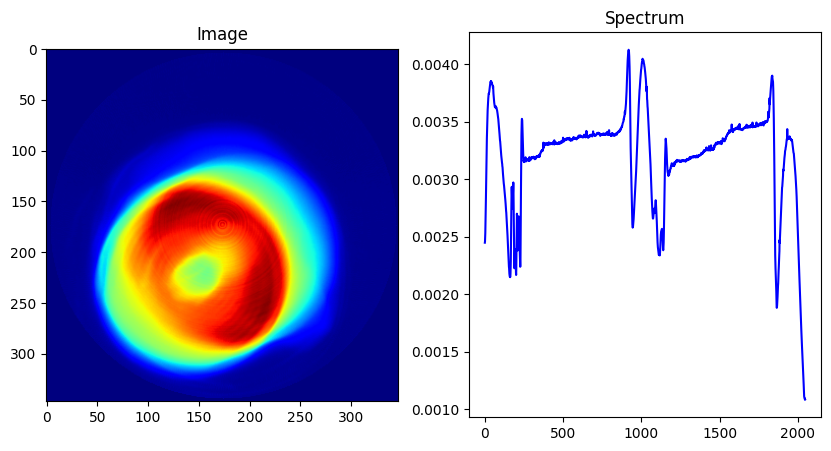

In [20]:
ImageSpectrumGUI(vol)


## 16. Ring artefact removal

We use use algotom's remove_stripe_based_sorting method which uses a 1D data sorting approach and median filter to remove the ring artefacts in real space i.e. the image is transformed from cartesian to polar coordinates, the filter is applied and then the image is converted back to cartesian coordinates. Alternatively, one can apply ring artefact removal algorithms to the sinogram data prior to reconstruction

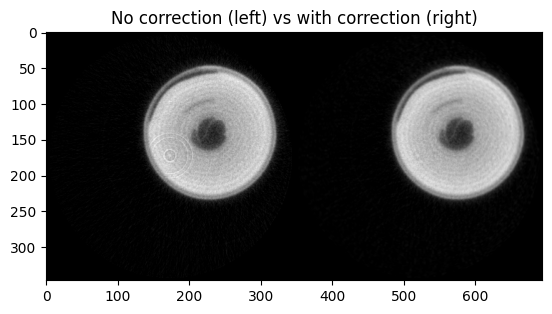

In [28]:
import algotom.util.utility as util
import algotom.prep.removal as remo

def ring_remover_post_recon_stripe(img, size=300, dim=1, **options):
    (nrow, ncol) = img.shape
    (x_mat, y_mat) = util.rectangular_from_polar(ncol, ncol, ncol, ncol)
    (r_mat, theta_mat) = util.polar_from_rectangular(ncol, ncol, ncol, ncol)
    polar_mat = util.mapping(img, x_mat, y_mat)
    polar_mat = remo.remove_stripe_based_sorting(polar_mat, size=size, dim=dim,  **options)
    mat_rec = util.mapping(polar_mat, r_mat, theta_mat)
    return mat_rec

ind = 400

im = np.copy(vol[:,:,ind])
imn = ring_remover_post_recon_stripe(im, size=11, dim=0)


plt.figure(1);plt.clf()
plt.imshow(np.concatenate((im, imn), axis =1), cmap = 'gray')
plt.title('No correction (left) vs with correction (right)')
plt.show()



In [29]:
for ii in tqdm(range(vol.shape[2])):
    vol[:,:,ii] = ring_remover_post_recon_stripe(vol[:,:,ii], size=11, dim=0 )

100%|██████████| 2048/2048 [02:01<00:00, 16.86it/s]


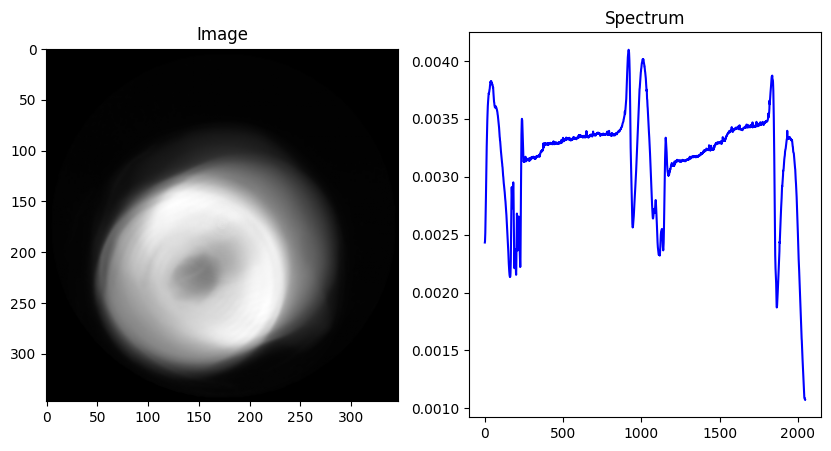

In [30]:
ImageSpectrumGUI(vol, cmap = 'gray')


## 17. Saving Processed Data

The final sinograms and reconstructed volume are saved into an HDF5 file (`.h5`) using `h5py`. Two datasets are stored:  

- `sinograms`: cleaned and centred sinograms.  
- `data`: reconstructed volume.  

This ensures both raw-intermediate and final processed data are preserved for downstream analysis.


In [ ]:

fn = '%s%s\\%s_processed.h5' %(p, datasets[dd], datasets[dd])
print(fn)   

with h5py.File(fn, 'w') as f:
    f.create_dataset('sinograms', data = sinos)
    f.create_dataset('data', data = vol)

# Summary

This notebook has demonstrated the full pipeline for processing neutron CT data:  
1. Load and average flats/darks  
2. Correct sick pixels  
3. Apply flat/dark normalisation  
4. Log transform and construct sinograms  
5. Centre the rotation axis  
6. Clean sinograms  
7. Reconstruct slices and full volume  
8. Remove ring artefacts in real space  
9. Save results for further use  

Each step includes visualisation and interactive inspection to ensure artefacts are identified and corrected before final reconstruction.